# Listening to the audio
This code enables you to listen to a sample sine wave audio.

In [93]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy
import torch

In [95]:
SAMPLE_RATE = 22050

In [96]:
T = 4.0    # seconds
t = np.linspace(0, T, int(T*SAMPLE_RATE), endpoint=False) # time variable
freq = 440
signal = np.sin(2*np.pi*freq*t)
ipd.Audio(signal, rate=SAMPLE_RATE)

# Creating spectrograms
Spectrograms provide a 2D feature space to analyze signals in the joint time-frequency domain.

This code generates the spectrogram files for use with the CNN example. It makes files for non-noised data!

In [98]:
# Just some re-shaping and dimension finding
N = 1
print "N:",N
train = signal[np.newaxis,:]
print "Train shape",train.shape
N_train = train.shape[0]
NUM_SAMPLES = train.shape[1]-1

X_train = train[:,:-1]
y_train = train[:,-1]
y_train = y_train.reshape(N_train,1)

N: 1
Train shape (1, 88200)


In [100]:
# JUST SOME FOURIER TRANSFORM PARAMETERS
BINS_OCTAVE = 12*2
N_OCTAVES = 7
NUM_BINS = BINS_OCTAVE * N_OCTAVES

In [101]:
# Given a wav time series, makes a mel spectrogram
# which is a short-time fourier transform with
# frequencies on the mel (log) scale.
def mel_spec(y):
    Q = librosa.cqt(y=y, sr=SAMPLE_RATE, bins_per_octave=BINS_OCTAVE,n_bins=NUM_BINS)
    Q_db = librosa.amplitude_to_db(Q,ref=np.max)
    return Q_db

In [102]:
# This means that the spectrograms are 168 rows (frequencies)
# By 173 columns (time frames)
song = X_train[0]
test_spec = mel_spec(song)
print test_spec.shape
FEATS = test_spec.shape[0]
FRAMES = test_spec.shape[1]

(168, 173)


/Users/MacBookAir/anaconda/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [103]:
tmp_train = np.zeros((N_train,FEATS,FRAMES))
for i in range(N_train):
    tmp_train[i,:,:] = mel_spec(X_train[i])
#np.save('Data/xtrain_spec', tmp_train)

In [106]:
tmp_train.shape

(1, 168, 173)

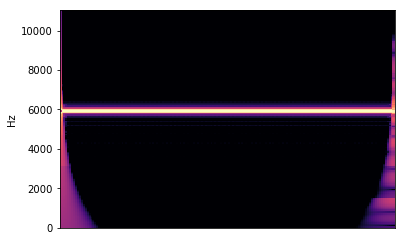

In [104]:
librosa.display.specshow(tmp_train[0], y_axis='hz')

# Training

In [108]:
from __future__ import division
from keras.layers import Convolution2D, MaxPool2D, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.models import Sequential, load_model
from keras.utils import np_utils

In [141]:
def fourier(X_train, FEATS=168, FRAMES=173):
    N_train = X_train.shape[0]
    tmp_train = np.zeros((N_train,FEATS,FRAMES))
    for i in range(N_train):
        tmp_train[i,:,:] = mel_spec(X_train[i])
    return tmp_train

def train_generator(fname='train.csv', step_size=5):
    for step in range(6325//step_size):
        df = pd.read_csv(fname, header=None, skiprows=step*step_size, nrows=step_size).values
        X_train, y_train = df[:,:-1], df[:,-1]
        X_train = fourier(X_train)
        X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
        y_train = np_utils.to_categorical(y_train,num_classes=10)
        yield (X_train, y_train)
            
def test_generator(fname='test.csv', step_size=5):
    for step in range(1000//step_size):
        df = pd.read_csv(fname, header=None, skiprows=step*step_size, nrows=step_size).values
        labels, X_test = df[:,0], df[:,1:]
        yield (labels, X_test)

In [142]:
# build model
model = Sequential()

model.add(Convolution2D(20, (4,4), strides=2, activation='relu', input_shape=(168,173,1)))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(20, (4,4), strides=2, activation='relu'))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(10, (4,4), strides=2, activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 83, 85, 20)        340       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 41, 42, 20)        0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 41, 42, 20)        80        
_________________________________________________________________
dropout_57 (Dropout)         (None, 41, 42, 20)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 19, 20, 20)        6420      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 9, 10, 20)         0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 9, 10, 20)         80        
__________

In [144]:
for epoch in range(10):
    for X_train, y_train in train_generator():
        model.fit(X_train, y_train, epochs=1, verbose=0, validation_split=0)

InvalidArgumentError: Node 'batch_normalization_37/cond/Switch': Unknown input node 'batch_normalization_1/keras_learning_phase'

# Predict

In [ ]:
preds, labels = [], []
for labels_curr, X_test in test_generator():
    preds_curr = np.argmax(model.predict(X_test), axis=1)
    labels += list(labels_curr)
    preds += list(preds_curr)

In [43]:
def write_to_file(filename, preds, labels):
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for l,p in zip(labels,preds):
            f.write(str(l)+','+str(p)+'\n')

In [ ]:
write_to_file('out.csv', preds, labels)